In [38]:
import math
import numpy as np
import pandas as pd
from sympy import *
from sympy.plotting import plot3d
import plotly.graph_objects as go
import plotly.express as px

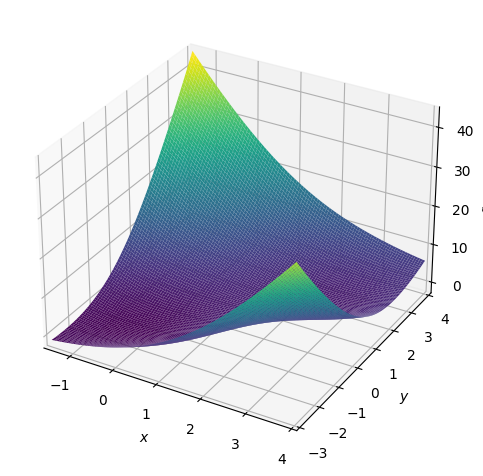

In [64]:
x, y = symbols("x y")

mc_cormick_finction = sin(x + y) + (x - y) ** 2 - 1.5 * x + 2.5 * y + 1
mc_cormick_global_min_x = -0.54719
mc_cormick_global_min_y = -1.54719
mc_cormick_global_min_value = -1.9133
mc_cormick_x_min_limit = -1.5
mc_cormick_x_max_limit = 4
mc_cormick_y_min_limit = -3
mc_cormick_y_max_limit = 4

plot3d(mc_cormick_finction, (x, mc_cormick_x_min_limit, mc_cormick_x_max_limit), (y, mc_cormick_y_min_limit, mc_cormick_y_max_limit), nb_of_points_x = 100, nb_of_points_y = 100)

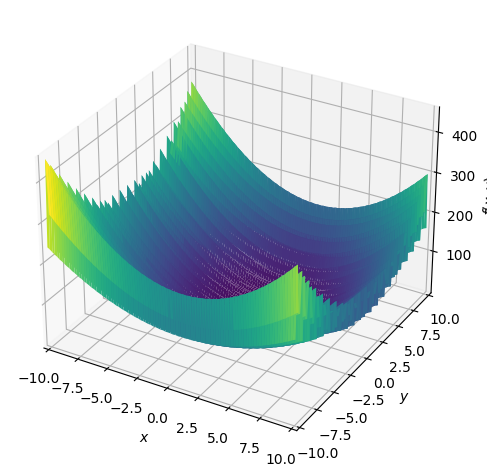

In [63]:
levi13_finction =  sin(3 * pi * x) ** 2 + (x - 1) ** 2 * (1 + sin(3 * pi * y) ** 2) + (y - 1) ** 2 * (1 + sin(2 * pi * y) ** 2)
levi13_global_min_x = 1
levi13_global_min_y = 1
levi13_global_min_value = 0
levi13_x_min_limit = -10
levi13_x_max_limit = 10
levi13_y_min_limit = -10
levi13_y_max_limit = 10

plot3d(levi13_finction, (x, levi13_x_min_limit, levi13_x_max_limit), (y, levi13_y_min_limit, levi13_y_max_limit), nb_of_points_x = 100, nb_of_points_y = 100)

In [43]:
def symbolic_diff(function, param, x_value, y_value):
    return float(function.diff(param).subs([(x, x_value), (y, y_value)]))

def numeric_diff(function, param, x_value, y_value, d_param):
    if param == x:
        return float((function.subs([(x, x_value + d_param), (y, y_value)]) + function.subs([(x, x_value - d_param), (y, y_value)])) / (2 * d_param))
    elif param == y:
        return float((function.subs([(x, x_value), (y, y_value + d_param)]) + function.subs([(x, x_value), (y, y_value - d_param)])) / (2 * d_param))

def gradient_magitude(x_diff, y_diff):
    return math.sqrt(x_diff ** 2 + y_diff ** 2)

def GD(function, start_x, start_y, lr, n_iter, use_symbolic_grad = True, h = 0.001, use_decay_lr = False, decay_factor = 0.9):
    history = {'x': [start_x],
               'y': [start_y],
               'z': [float(function.subs([(x, start_x), (y, start_y)]))]}
    for _ in range(n_iter):
        if use_symbolic_grad:
            step_x = -lr * symbolic_diff(function, x, history['x'][-1], history['y'][-1])
            step_y = -lr * symbolic_diff(function, y, history['x'][-1], history['y'][-1])
        else:
            step_x = -lr * numeric_diff(function, x, history['x'][-1], history['y'][-1], h)
            step_y = -lr * numeric_diff(function, y, history['x'][-1], history['y'][-1], h)

        next_x = history['x'][-1] + step_x
        next_y = history['y'][-1] + step_y

        history['x'].append(next_x)
        history['y'].append(next_y)
        history['z'].append(float(function.subs([(x, next_x), (y, next_y)])))

        if use_decay_lr:
            lr *= decay_factor

    return history

def AGD_nesterov_momentum(function, start_x, start_y, lr, n_iter, beta = 0.9, use_symbolic_grad = True, h = 0.001, use_decay_lr = False, decay_factor = 0.9):
    history = {'x': [start_x],
               'y': [start_y],
               'z': [float(function.subs([(x, start_x), (y, start_y)]))]}
    
    if use_symbolic_grad:
        v_x = -lr * symbolic_diff(function, x, history['x'][-1], history['y'][-1])
        v_y = -lr * symbolic_diff(function, y, history['x'][-1], history['y'][-1])
    else:
        v_x = -lr * numeric_diff(function, x, history['x'][-1], history['y'][-1], h)
        v_y = -lr * numeric_diff(function, y, history['x'][-1], history['y'][-1], h)
        
    for _ in range(n_iter):
        if use_symbolic_grad:
            v_x = beta * v_x - lr * symbolic_diff(function, x, history['x'][-1] + v_x, history['y'][-1] + v_y)
            v_y = beta * v_y - lr * symbolic_diff(function, y, history['x'][-1] + v_x, history['y'][-1] + v_y)
        else:
            step_x = -lr * numeric_diff(function, x, history['x'][-1], history['y'][-1], h)
            step_y = -lr * numeric_diff(function, y, history['x'][-1], history['y'][-1], h)

        next_x = history['x'][-1] + v_x
        next_y = history['y'][-1] + v_y

        history['x'].append(next_x)
        history['y'].append(next_y)
        history['z'].append(float(function.subs([(x, next_x), (y, next_y)])))

        if use_decay_lr:
            lr *= decay_factor

    return history

def RMSProp(function, start_x, start_y, lr, n_iter, gamma = 0.1, use_symbolic_grad = True, h = 0.001, use_decay_lr = False, decay_factor = 0.9):
    e = 1e-7
    
    history = {'x': [start_x],
               'y': [start_y],
               'z': [float(function.subs([(x, start_x), (y, start_y)]))]}
    
    if use_symbolic_grad:
        G = gradient_magitude(symbolic_diff(function, x, history['x'][-1], history['y'][-1]), 
                              symbolic_diff(function, y, history['x'][-1], history['y'][-1]))
    else:
        G = gradient_magitude(numeric_diff(function, x, history['x'][-1], history['y'][-1], h), 
                              numeric_diff(function, y, history['x'][-1], history['y'][-1], h))
    
    for _ in range(n_iter):
        if use_symbolic_grad:
            G = gamma * G + (1 - gamma) * gradient_magitude(symbolic_diff(function, x, history['x'][-1], history['y'][-1]), 
                                                            symbolic_diff(function, y, history['x'][-1], history['y'][-1]))
        else:
            G = gamma * G + (1 - gamma) * gradient_magitude(numeric_diff(function, x, history['x'][-1], history['y'][-1], h), 
                                                            numeric_diff(function, y, history['x'][-1], history['y'][-1], h))
        
        if use_symbolic_grad:
            step_x = (-lr * symbolic_diff(function, x, history['x'][-1], history['y'][-1])) / math.sqrt(G + e)
            step_y = (-lr * symbolic_diff(function, y, history['x'][-1], history['y'][-1])) / math.sqrt(G + e)
        else:
            step_x = (-lr * numeric_diff(function, x, history['x'][-1], history['y'][-1], h)) / math.sqrt(G + e)
            step_y = (-lr * numeric_diff(function, y, history['x'][-1], history['y'][-1], h)) / math.sqrt(G + e)

        next_x = history['x'][-1] + step_x
        next_y = history['y'][-1] + step_y

        history['x'].append(next_x)
        history['y'].append(next_y)
        history['z'].append(float(function.subs([(x, next_x), (y, next_y)])))

        if use_decay_lr:
            lr *= decay_factor

    return history

In [65]:
def plot_history(test_function, history, 
                 xmin, xmax,
                 ymin, ymax,
                 n_x_samples = 100, n_y_samples = 100,
                 line_span = 5):
    
    x_linspace = np.linspace(xmin, xmax, n_x_samples)
    y_linspace = np.linspace(ymin, ymax, n_y_samples)

    xx, yy = np.meshgrid(x_linspace, y_linspace)

    fxy = lambdify((x,y), test_function, 'numpy')

    zz = fxy(xx, yy)

    line = go.Scatter3d(x=history['x'], 
                        y=history['y'], 
                        z=history['z'], 
                        mode='lines', 
                        line=dict(
                            color='green',
                            width=10
                        ))
    
    surface = go.Surface(x = xx, y = yy, z = zz)
    
    frames = []
    for i in range(len(history['z'])):
        if i < line_span:
            shift = I
        else:
            shift = line_span
        
        frames.append(go.Frame(data=[go.Scatter3d(x=[history['x'][i]], 
                                                  y=[history['y'][i]], 
                                                  z=[history['z'][i]],
                                                  mode="markers",
                                                  marker=dict(color="cyan", size=5))]))
    
    fig = go.Figure(data = [surface, line, surface], frames = frames,
            layout=go.Layout(
            xaxis=dict(range=[0, 5], autorange=False),
            yaxis=dict(range=[0, 5], autorange=False),

            updatemenus=[dict(
                type="buttons",
                buttons=[
                    dict(label="Play",
                         method="animate",
                         args=[None, 
                               {"frame": {"duration": 500}}])])]))
    fig.show()

In [59]:
history = RMSProp(mc_cormick_finction, 4, 0, 0.1, 100, 0)

In [66]:
plot_history(mc_cormick_finction, history, 
             mc_cormick_x_min_limit, mc_cormick_x_max_limit,
             mc_cormick_y_min_limit, mc_cormick_y_max_limit)